In [61]:
!pip install pycuda

In [62]:
!git clone https://github.com/lebedov/scikit-cuda.git

import os
work_dir = os.getcwd()
#!ls
os.chdir(work_dir)
os.chdir('scikit-cuda')
%run setup.py install

# add scikit-cuda to the PYTHONPATH
import sys
sys.path.append(os.getcwd())
os.chdir(work_dir)

fatal: destination path 'scikit-cuda' already exists and is not an empty directory.
running install
running bdist_egg
running egg_info
writing scikit_cuda.egg-info/PKG-INFO
writing dependency_links to scikit_cuda.egg-info/dependency_links.txt
writing namespace_packages to scikit_cuda.egg-info/namespace_packages.txt
writing requirements to scikit_cuda.egg-info/requires.txt
writing top-level names to scikit_cuda.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'scikit_cuda.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/scikits
copying build/lib/scikits/__init__.py -> build/bdist.linux-x86_64/egg/scikits
creating build/bdist.linux-x86_64/egg/scikits/cuda
copying build/lib/scikits/cuda/__init__.py -> build/bdist.linux-x86_64/egg/scikits/cuda
creating build/bdist.linux-x86_64/egg/skcuda
copying build/lib/skcuda/ve

zip_safe flag not set; analyzing archive contents...
scikits.__pycache__.__init__.cpython-36: module references __path__
scikits.cuda.__pycache__.__init__.cpython-36: module references __file__
scikits.cuda.__pycache__.__init__.cpython-36: module references __path__
skcuda.__pycache__.__init__.cpython-36: module references __file__
skcuda.__pycache__.__init__.cpython-36: module references __path__


creating 'dist/scikit_cuda-0.5.4-py3.6.egg' and adding 'build/bdist.linux-x86_64/egg' to it
removing 'build/bdist.linux-x86_64/egg' (and everything under it)
Processing scikit_cuda-0.5.4-py3.6.egg
removing '/usr/local/lib/python3.6/dist-packages/scikit_cuda-0.5.4-py3.6.egg' (and everything under it)
creating /usr/local/lib/python3.6/dist-packages/scikit_cuda-0.5.4-py3.6.egg
Extracting scikit_cuda-0.5.4-py3.6.egg to /usr/local/lib/python3.6/dist-packages
scikit-cuda 0.5.4 is already the active version in easy-install.pth

Installed /usr/local/lib/python3.6/dist-packages/scikit_cuda-0.5.4-py3.6.egg
Processing dependencies for scikit-cuda==0.5.4
Searching for pycuda==2020.1
Best match: pycuda 2020.1
Adding pycuda 2020.1 to easy-install.pth file

Using /usr/local/lib/python3.6/dist-packages
Searching for numpy==1.18.5
Best match: numpy 1.18.5
Adding numpy 1.18.5 to easy-install.pth file
Installing f2py script to /usr/local/bin
Installing f2py3 script to /usr/local/bin
Installing f2py3.6 sc

<Figure size 432x288 with 0 Axes>

In [63]:
# https://arxiv.org/pdf/1211.4943.pdf

import numpy as np

import matplotlib.pyplot as plt

from scipy.special import legendre
from scipy.special import iv
from scipy.special import jv
from scipy.special import spherical_jn
from scipy.special import gamma

from scipy.io import loadmat

import scikits.cuda.fft as fft

import time

import pycuda.gpuarray as gpuarray
import  pycuda.driver   as      cuda
import  pycuda.autoinit
from    pycuda.compiler import  SourceModule
from    pycuda.compiler import  DynamicSourceModule

In [64]:
def NUDFT_NED_2D(data, x, y, N, M):

  u       = np.arange(-N / 2, N / 2)
  v       = np.arange(-M / 2, M / 2)

  U, V    = np.meshgrid(u, v)

  U       = np.reshape(U, (N * M, 1))
  V       = np.reshape(V, (N * M, 1))

  X, U    = np.meshgrid(x, U)
  Y, V    = np.meshgrid(y, V)

  Kernel  = np.exp(-1j * 2 * np.pi * X * U / N) * np.exp(-1j * 2 * np.pi * Y * V / M)

  transf = np.reshape(np.matmul(Kernel, data), (M, N))

  return transf

In [65]:
def NUFFT_NED_2D(data, c, K, x1, x2, M1, M2):
   
  N = data.size                                 # --- Number of input elements                     

  # --- Algorithm parameters
  alfa        = (2 - 1 / c) * np.pi - 0.01      # --- Half-size of the support of the interpolation window

  x1    = np.reshape(x1, (x1.size))
  x2    = np.reshape(x2, (x2.size))
  data  = np.reshape(data, (data.size))

  ###################
  # SPECTRAL WINDOW #
  ###################
  mu1 = np.round(c * x1)                                         
  mu2 = np.round(c * x2)                                         
  
  KK1, MU1  = np.meshgrid(np.arange(-K, K + 1), mu1)
  X1        = np.matmul(np.reshape(x1, (x1.size, 1)), np.ones((1, 2 * K + 1)))
  P1        = np.sqrt(K**2 - (c * X1 - (MU1 + KK1))**2 + 1j * 0.)
  phi_cap1  = (1 / np.pi) * np.sinh(alfa * P1) / P1
  phi_cap1[np.where(P1 == (0. + 1j * 0.))] = alfa / np.pi

  KK2, MU2  = np.meshgrid(np.arange(-K, K + 1), mu2)
  X2        = np.matmul(np.reshape(x2, (x2.size, 1)), np.ones((1, 2 * K + 1)))
  P2        = np.sqrt(K**2 - (c * X2 - (MU2 + KK2))**2 + 1j * 0.)
  phi_cap2  = (1 / np.pi) * np.sinh(alfa * P2) / P2
  phi_cap2[np.where(P2 == (0. + 1j * 0.))] = alfa / np.pi

  ##################
  # SPATIAL WINDOW #
  ##################
  kk1       = np.arange(-M1 / 2, M1 / 2)
  xi1       = 2 * np.pi * kk1 / (c * M1)
  phi1      = iv(0, K * np.sqrt(alfa**2 - xi1**2))
    
  kk2       = np.arange(-M2 / 2, M2 / 2)
  xi2       = 2 * np.pi * kk2 / (c * M2)
  phi2      = iv(0, K * np.sqrt(alfa**2 - xi2**2))

  PHI2, PHI1 = np.meshgrid(phi2, phi1)

  ###########################################
  # STEP 1: Evaluating Fourier coefficients #
  ###########################################
  if (K == 6):
    u = np.zeros((int(c * M1), int(c * M2)), dtype = np.complex128)
  else:
    u = np.zeros((int(c * M1), int(c * M2)), dtype = np.complex64)
  for k in range(N):
    for l1 in np.arange(-K, K + 1):
        for l2 in np.arange(-K, K + 1):
            p1 = np.int32(np.mod(mu1[k] + l1 + M1 * c / 2, c * M1))
            p2 = np.int32(np.mod(mu2[k] + l2 + M2 * c / 2, c * M2))
            u[p1, p2] = u[p1, p2] + data[k] * phi_cap1[k, l1 + K] * phi_cap2[k, l2 + K]

  '''plt.imshow(np.abs(u))
  plt.colorbar()
  plt.show()'''
  
  ##############################
  # STEP 2: FFT over cN points #
  ##############################
  #temp = np.fft.fft2(np.fft.ifftshift(u))
  FFT_Mc = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(u)))

  ##################################
  # STEP 3: Decimation and scaling #
  ##################################
  transf = FFT_Mc[np.int32((c - 1) * M1 / 2) : np.int32((c + 1) * M1 / 2), np.int32((c - 1) * M2 / 2) : np.int32((c + 1) * M2 / 2)] / (PHI1 * PHI2)

  return transf, FFT_Mc

In [66]:
def fma(a, x, b):
  return a * x + b

def spectralWindowOpt_c_2_K_6(c, K, alfa_prime, x, M):

  mm                = np.arange(-K, K + 1)
  
  mu                = np.round(c * x)   
  kk                = np.arange(-M / 2, M / 2)
  xi                = 2 * np.pi * kk / (c * M)
  phi_cap           = np.zeros((2 * K + 1, x.size))
  XX, MM            = np.meshgrid(x, mm)

  a                 = alfa_prime * (K + 1)

  argBessel         = alfa_prime * np.abs(c * XX - (MM + np.round(c * XX))) 

  x_in              = 2. * np.abs(argBessel) / a - 1.
  
  fma_temp          = fma(-0.000001129163478, x_in,  0.000003165164415)
  fma_temp          = fma(fma_temp,           x_in,  0.000007321870199)
  fma_temp          = fma(fma_temp,           x_in, -0.000027220682469)
  fma_temp          = fma(fma_temp,           x_in, -0.000015646508843)
  fma_temp          = fma(fma_temp,           x_in,  0.000106469005835)
  fma_temp          = fma(fma_temp,           x_in, -0.000008371029749)
  fma_temp          = fma(fma_temp,           x_in, -0.000251483307759)
  fma_temp          = fma(fma_temp,           x_in,  0.000139522082968)
  fma_temp          = fma(fma_temp,           x_in,  0.000398054756073)
  fma_temp          = fma(fma_temp,           x_in, -0.000527575162925)
  fma_temp          = fma(fma_temp,           x_in, -0.000365407775081)
  fma_temp          = fma(fma_temp,           x_in,  0.001728505313358)
  fma_temp          = fma(fma_temp,           x_in, -0.000634718329590)
  fma_temp          = fma(fma_temp,           x_in, -0.005604841924036)
  fma_temp          = fma(fma_temp,           x_in,  0.006674098430928)
  fma_temp          = fma(fma_temp,           x_in,  0.015620491928147)
  fma_temp          = fma(fma_temp,           x_in, -0.033402006733755)
  fma_temp          = fma(fma_temp,           x_in, -0.029140004798537)
  fma_temp          = fma(fma_temp,           x_in,  0.121571525882699)
  fma_temp          = fma(fma_temp,           x_in,  0.002106046258864)
  fma_temp          = fma(fma_temp,           x_in, -0.326126189288748)
  fma_temp          = fma(fma_temp,           x_in,  0.222001162358188)
  fma_temp          = fma(fma_temp,           x_in,  0.591418614354732)
  fma_temp          = fma(fma_temp,           x_in, -0.900507059587342)
  fma_temp          = fma(fma_temp,           x_in, -0.483641444241807)
  fma_temp          = fma(fma_temp,           x_in,  1.971163139788472)
  fma_temp          = fma(fma_temp,           x_in, -0.742149540285898)
  fma_temp          = fma(fma_temp,           x_in, -2.302724830365524)
  fma_temp          = fma(fma_temp,           x_in,  2.835300601791355)
  fma_temp          = fma(fma_temp,           x_in,  0.362224899588647)
  fma_temp          = fma(fma_temp,           x_in, -3.232336104716730)
  fma_temp          = fma(fma_temp,           x_in,  2.447888731409964)
  fma_temp          = fma(fma_temp,           x_in,  0.345397722277477)
  fma_temp          = fma(fma_temp,           x_in, -1.889371969742727)
  fma_temp          = fma(fma_temp,           x_in,  1.538300766008014)
  fma_temp          = fma(fma_temp,           x_in, -0.648645858694633)
  fma_temp          = fma(fma_temp,           x_in,  0.147993512467234)
  fma_temp          = fma(fma_temp,           x_in, -0.014562948397935)
   
  phi_cap = np.transpose(fma_temp)

  return mu, phi_cap, xi

def spectralWindowOpt_c_1_5_K_6(c, K, alfa_prime, x, M):

  mm                = np.arange(-K, K + 1)
  
  mu                = np.round(c * x)   
  kk                = np.arange(-M / 2, M / 2)
  xi                = 2 * np.pi * kk / (c * M)
  phi_cap           = np.zeros((2 * K + 1, x.size))
  XX, MM            = np.meshgrid(x, mm)

  a                 = alfa_prime * (K + 1)

  argBessel         = alfa_prime * np.abs(c * XX - (MM + np.round(c * XX))) 

  x_in              = 2. * np.abs(argBessel) / a - 1.
  
  fma_temp          = fma(0.000003492736408,   x_in,  0.000003081779861)
  fma_temp          = fma(fma_temp,            x_in, -0.000046616298327)
  fma_temp          = fma(fma_temp,            x_in, -0.000024404893476)
  fma_temp          = fma(fma_temp,            x_in,  0.000336368565843)
  fma_temp          = fma(fma_temp,            x_in,  0.000029917631213)
  fma_temp          = fma(fma_temp,            x_in, -0.001743668848001)
  fma_temp          = fma(fma_temp,            x_in,  0.000708500840991)
  fma_temp          = fma(fma_temp,            x_in,  0.007014620685846)
  fma_temp          = fma(fma_temp,            x_in, -0.006799748741222)
  fma_temp          = fma(fma_temp,            x_in, -0.021529321749036)
  fma_temp          = fma(fma_temp,            x_in,  0.036549468510434)
  fma_temp          = fma(fma_temp,            x_in,  0.044521193572278)
  fma_temp          = fma(fma_temp,            x_in, -0.136492248521661)
  fma_temp          = fma(fma_temp,            x_in, -0.028033899249125)
  fma_temp          = fma(fma_temp,            x_in,  0.359670808810277)
  fma_temp          = fma(fma_temp,            x_in, -0.191853263665985)
  fma_temp          = fma(fma_temp,            x_in, -0.610117205155395)
  fma_temp          = fma(fma_temp,            x_in,  0.818503581238404)
  fma_temp          = fma(fma_temp,            x_in,  0.415726049485544)
  fma_temp          = fma(fma_temp,            x_in, -1.576607081592846)
  fma_temp          = fma(fma_temp,            x_in,  0.699211693344845)
  fma_temp          = fma(fma_temp,            x_in,  1.307219314857228)
  fma_temp          = fma(fma_temp,            x_in, -1.821356733059523)
  fma_temp          = fma(fma_temp,            x_in,  0.408485365962472)
  fma_temp          = fma(fma_temp,            x_in,  0.988620821433048)
  fma_temp          = fma(fma_temp,            x_in, -1.134132506968317)
  fma_temp          = fma(fma_temp,            x_in,  0.577470961644376)
  fma_temp          = fma(fma_temp,            x_in, -0.152296947615356)
  fma_temp          = fma(fma_temp,            x_in,  0.016958405256447)
   
  phi_cap = np.transpose(fma_temp)

  return mu, phi_cap, xi

In [67]:
def spatialWindowOpt_c_2_K_6(xi):

  x_in      = (2. * c - 1.) * xi / (2. * np.pi - np.pi / c)
  
  phi       = np.zeros((1, xi.size))
  
  fma_temp          = fma(-0.000036133231311,  x_in,  0.000027431424929)
  fma_temp          = fma(fma_temp,            x_in,  0.000331339031581)
  fma_temp          = fma(fma_temp,            x_in, -0.000234668291557)
  fma_temp          = fma(fma_temp,            x_in, -0.001396027154939)
  fma_temp          = fma(fma_temp,            x_in,  0.000916413320840)
  fma_temp          = fma(fma_temp,            x_in,  0.003581825384835)
  fma_temp          = fma(fma_temp,            x_in, -0.002162764235051)
  fma_temp          = fma(fma_temp,            x_in, -0.006253147831944)
  fma_temp          = fma(fma_temp,            x_in,  0.003441695028803)
  fma_temp          = fma(fma_temp,            x_in,  0.007861787452553)
  fma_temp          = fma(fma_temp,            x_in, -0.003901100279692)
  fma_temp          = fma(fma_temp,            x_in, -0.007348431684828)
  fma_temp          = fma(fma_temp,            x_in,  0.003242885102767)
  fma_temp          = fma(fma_temp,            x_in,  0.005197199182402)
  fma_temp          = fma(fma_temp,            x_in, -0.002004818051995)
  fma_temp          = fma(fma_temp,            x_in, -0.002799941184903)
  fma_temp          = fma(fma_temp,            x_in,  0.000924367333247)
  fma_temp          = fma(fma_temp,            x_in,  0.001108509166428)
  fma_temp          = fma(fma_temp,            x_in, -0.000315531427948)
  fma_temp          = fma(fma_temp,            x_in,  0.000022538097428)
  fma_temp          = fma(fma_temp,            x_in,  0.000078226257245)
  fma_temp          = fma(fma_temp,            x_in, -0.002611590196869)
  fma_temp          = fma(fma_temp,            x_in, -0.000013580764606)
  fma_temp          = fma(fma_temp,            x_in,  0.016258902472516)
  fma_temp          = fma(fma_temp,            x_in,  0.000001540084659)
  fma_temp          = fma(fma_temp,            x_in, -0.083180834403607)
  fma_temp          = fma(fma_temp,            x_in, -0.000000097319106)
  fma_temp          = fma(fma_temp,            x_in,  0.352708417507330)
  fma_temp          = fma(fma_temp,            x_in,  0.000000001729655)
  fma_temp          = fma(fma_temp,            x_in, -1.205895872832613)
  fma_temp          = fma(fma_temp,            x_in,  0.000000000082329)
  fma_temp          = fma(fma_temp,            x_in,  3.190885437184177)
  fma_temp          = fma(fma_temp,            x_in,  0.000000000006335)
  fma_temp          = fma(fma_temp,            x_in, -6.125383620022527)
  fma_temp          = fma(fma_temp,            x_in, -0.000000000000871)
  fma_temp          = fma(fma_temp,            x_in,  7.581967204609319)
  fma_temp          = fma(fma_temp,            x_in,  0.000000000000018)
  phi               = fma(fma_temp,            x_in, -4.538305067483899)
  
  return phi

def spatialWindowOpt_c_1_5_K_6(xi):

  x_in      = (2. * c - 1.) * xi / (2. * np.pi - np.pi / c)
  
  phi       = np.zeros((1, xi.size))
  
  fma_temp          = fma(-0.000000069910102,  x_in,  0.000009440083978)
  fma_temp          = fma(fma_temp,            x_in,  0.000000485373669)
  fma_temp          = fma(fma_temp,            x_in, -0.000130542860824)
  fma_temp          = fma(fma_temp,            x_in, -0.000001511196733)
  fma_temp          = fma(fma_temp,            x_in,  0.001007181146599)
  fma_temp          = fma(fma_temp,            x_in,  0.000002786045376)
  fma_temp          = fma(fma_temp,            x_in, -0.005861791424619)
  fma_temp          = fma(fma_temp,            x_in, -0.000003382240723)
  fma_temp          = fma(fma_temp,            x_in,  0.028542361926637)
  fma_temp          = fma(fma_temp,            x_in,  0.000002843935263)
  fma_temp          = fma(fma_temp,            x_in, -0.119965156296017)
  fma_temp          = fma(fma_temp,            x_in, -0.000001695763776)
  fma_temp          = fma(fma_temp,            x_in,  0.436044809334474)
  fma_temp          = fma(fma_temp,            x_in,  0.000000721634603)
  fma_temp          = fma(fma_temp,            x_in, -1.357516364933031)
  fma_temp          = fma(fma_temp,            x_in, -0.000000217506622)
  fma_temp          = fma(fma_temp,            x_in,  3.564588400278597)
  fma_temp          = fma(fma_temp,            x_in,  0.000000045421100)
  fma_temp          = fma(fma_temp,            x_in, -7.731821324183906)
  fma_temp          = fma(fma_temp,            x_in, -0.000000006311966)
  fma_temp          = fma(fma_temp,            x_in, 13.464987789472458)
  fma_temp          = fma(fma_temp,            x_in,  0.000000000545447)
  fma_temp          = fma(fma_temp,            x_in,-18.069347531398041)
  fma_temp          = fma(fma_temp,            x_in, -0.000000000026086)
  fma_temp          = fma(fma_temp,            x_in, 17.513523641932530)
  fma_temp          = fma(fma_temp,            x_in,  0.000000000000553)
  fma_temp          = fma(fma_temp,            x_in,-10.896373263737980)
  fma_temp          = fma(fma_temp,            x_in, -0.000000000000003)
  phi               = fma(fma_temp,            x_in,  3.263548456418927)
  
  return phi

In [68]:
def NUFFT_NED_2D_opt(data, x1, x2, M1, M2, c, K):

  N = data.size                                 # --- Number of input elements                     

  # --- Algorithm parameters
  alfa        = (2 - 1 / c) * np.pi - 0.01      # --- Half-size of the support of the interpolation window
  alfa_prime  = (2 - 1 / c) * np.pi

  ####################
  # SPECTRAL WINDOWS #
  ####################
  if ((c == 2) & (K == 6)):
    mu1, phi_cap1, xi1 = spectralWindowOpt_c_2_K_6(c, K, alfa_prime, x1, M1)
    mu2, phi_cap2, xi2 = spectralWindowOpt_c_2_K_6(c, K, alfa_prime, x2, M2)
  if ((c == 1.5) & (K == 6)):
    mu1, phi_cap1, xi1 = spectralWindowOpt_c_1_5_K_6(c, K, alfa_prime, x1, M1)
    mu2, phi_cap2, xi2 = spectralWindowOpt_c_1_5_K_6(c, K, alfa_prime, x2, M2)

  ###################
  # SPECTRAL WINDOW #
  ###################
  # --- Recovering the "optimal" spatial window by the Legendre Polynomials
  if ((c == 2) & (K == 6)):
    phi1 = spatialWindowOpt_c_2_K_6(xi1)
    phi2 = spatialWindowOpt_c_2_K_6(xi2)
  if ((c == 1.5) & (K == 6)):
    phi1 = spatialWindowOpt_c_1_5_K_6(xi1)
    phi2 = spatialWindowOpt_c_1_5_K_6(xi2)

  PHI2, PHI1 = np.meshgrid(phi2, phi1)

  ###########################################
  # STEP 1: Evaluating Fourier coefficients #
  ###########################################
  if (K == 6):
    u = np.zeros((int(c * M1), int(c * M2)), dtype = np.complex128)
  else:
    u = np.zeros((int(c * M1), int(c * M2)), dtype = np.complex64)
  for k in range(N):
    for l1 in np.arange(-K, K + 1):
        for l2 in np.arange(-K, K + 1):
            p1 = np.int32(np.mod(mu1[k] + l1 + M1 * c / 2, c * M1))
            p2 = np.int32(np.mod(mu2[k] + l2 + M2 * c / 2, c * M2))
            u[p1, p2] = u[p1, p2] + data[0, k] * phi_cap1[k, l1 + K] * phi_cap2[k, l2 + K]

  ##############################
  # STEP 2: FFT over cN points #
  ##############################
  FFT_Mc = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(u)))

  ##################################
  # STEP 3: Decimation and scaling #
  ##################################
  transf = FFT_Mc[np.int32((c - 1) * M1 / 2) : np.int32((c + 1) * M1 / 2), np.int32((c - 1) * M2 / 2) : np.int32((c + 1) * M2 / 2)] / (PHI1 * PHI2)

  return transf

In [69]:
###################
# iDivUp FUNCTION #
###################
def iDivUp(a, b):
    # Round a / b to nearest higher integer value
    a = np.int32(a)
    b = np.int32(b)
    return (a / b + 1) if (a % b != 0) else (a / b)

###############################################
# MODIFIED BESSEL FUNCTION CALCULATION KERNEL #
###############################################

GPUCode = """

#define pi_double	3.141592653589793238463

#define alpha 4.702388980384690

#define IDX2R(i, j, N) (((i) * (N)) + (j))

/***************************************/
/* ATOMIC ADDITION FUNCTION ON DOUBLES */
/***************************************/
#if !defined(__CUDA_ARCH__) || __CUDA_ARCH__ >= 600
#else
__device__ double atomicAdd(double* address, double val)
{
	unsigned long long int* address_as_ull =
		(unsigned long long int*)address;
	register unsigned long long int old = *address_as_ull, assumed;
	do {
		assumed = old;
		old = atomicCAS(address_as_ull, assumed,
			__double_as_longlong(val +
				__longlong_as_double(assumed)));
	} while (assumed != old);
	return __longlong_as_double(old);
}
#endif

__global__ void fftshift_2D_float(float2 * __restrict__ data, const int N1, const int N2)
{
    int i = threadIdx.x + blockDim.x * blockIdx.x;
    int j = threadIdx.y + blockDim.y * blockIdx.y;

    if (i < N1 && j < N2) {
		data[i*N2+j].x *= 1-2*((i+j)&1);
		data[i*N2+j].y *= 1-2*((i+j)&1);
	}
}

/*__global__ void fftshift_2D_double(double2 * __restrict__ data, const int N1, const int N2)
{
    int i = threadIdx.x + blockDim.x * blockIdx.x;
    int j = threadIdx.y + blockDim.y * blockIdx.y;

    if (i < N1 && j < N2) {
		data[i*N2+j].x *= 1-2*((i+j)&1);
		data[i*N2+j].y *= 1-2*((i+j)&1);
	}
}*/

__global__ void fftshift_2D_double(double2 * __restrict__ data, const int N1, const int N2)
{
    int i = threadIdx.x + blockDim.x * blockIdx.x;
    int j = threadIdx.y + blockDim.y * blockIdx.y;

    if (i < N1 && j < N2) {
			double2 temp = data[i * N2 + j];
			double  arg1 = 0.5 * (double)i * (1. - 1. / (double)N1);
			double  arg2 = 0.5 * (double)j * (1. - 1. / (double)N2);
			double  arg  = -2. * pi_double * (arg1 + arg2);
			data[i * N2 + j].x = temp.x * cos(arg) - temp.y * sin(arg);
			data[i * N2 + j].y = temp.y * cos(arg) + temp.x * sin(arg);
		}
}

__global__ void circshift(double2 * __restrict__ out, const double2 * __restrict__ in, const int xdim, const int ydim, const int xshift, const int yshift)
{
    int i = threadIdx.x + blockDim.x * blockIdx.x;
    int j = threadIdx.y + blockDim.y * blockIdx.y;

    if (i < xdim && j < ydim) {
			const int ii = (i + xshift) % xdim;
			const int jj = (j + yshift) % ydim;
			out[ii * ydim + jj] = in[i * ydim + j];
		}
}

__device__ int modulo(int val, int _mod)
{
	int P;
	if (val > 0) { (!(_mod & (_mod - 1)) ? P = val&(_mod - 1) : P = val % (_mod)); return P; }
	else
	{
		(!(_mod & (_mod - 1)) ? P = (-val)&(_mod - 1) : P = (-val) % (_mod));
		if (P > 0) return _mod - P;
		else return 0;
	}
}
	
__device__ double spectralWindowKB_NFFT2_2D_c_2_K_6(const double P) {

	double tempd, phi_cap;
	if (P < 0.) {
		tempd 		= rsqrt(-P); 
		phi_cap  	= static_cast<double>(1. / pi_double) * ((sin(4.702388980384690 / tempd)) * tempd);  }
	else if (P > 0.) {
		tempd     = rsqrt(P); 
		phi_cap   = static_cast<double>(1. / pi_double) * ((sinh(4.702388980384690 / tempd)) * tempd); }
	else 
	  phi_cap  = static_cast<double>(4.702388980384690 / pi_double);

  return phi_cap;

}

__device__ double spectralWindowKB_NFFT2_2D_c_1_5_K_6(const double P) {

	double tempd, phi_cap;
	if (P < 0.) {
		tempd 		= rsqrt(-P); 
		phi_cap  	= static_cast<double>(1. / pi_double) * ((sin(4.178790204786392 / tempd)) * tempd);  }
	else if (P > 0.) {
		tempd     = rsqrt(P); 
		phi_cap   = static_cast<double>(1. / pi_double) * ((sinh(4.178790204786392 / tempd)) * tempd); }
	else 
	  phi_cap  = static_cast<double>(4.178790204786392 / pi_double);

  return phi_cap;

}

__global__ void interpolationKB_NFFT2_2D_c_2_K_6(const double2* __restrict__ data, double2* __restrict__ result, const double* __restrict__ x, const double* __restrict__ y, const int N1, const int N2, int M)
{
	int i = threadIdx.x + blockDim.x * blockIdx.x;
	int m = threadIdx.y + blockDim.y * blockIdx.y;
	int n = threadIdx.z + blockDim.z * blockIdx.z;

	//double cc_points1=cc*x[i];
	double cc_points1 = 2. * x[i];
	double r_cc_points1=rint(cc_points1);				// It is the mu in Fourmont's paper
	const double cc_diff1 = cc_points1-r_cc_points1;

	//double cc_points2=cc*y[i];
	double cc_points2 = 2. * y[i];
	double r_cc_points2=rint(cc_points2);				// It is the mu in Fourmont's paper
	const double cc_diff2 = cc_points2-r_cc_points2;

	int PP1, PP2;
	double P1, P2;

	double phi_cap1, phi_cap2;

	if ((i < M) && (m < 13) && (n < 13)) {

		P1 				= 36. - (cc_diff1 - (double)(m - 6)) * (cc_diff1 - (double)(m - 6));

		//PP1 			= modulo((r_cc_points1 + (m - K) + N1 * cc / 2), cc * N1);
		PP1 			= modulo((r_cc_points1 + (double)(m - 6) + N1), 2 * N1);

		phi_cap1 	= spectralWindowKB_NFFT2_2D_c_2_K_6(P1);
			
		P2 				= 36. - (cc_diff2 - (double)(n - 6)) * (cc_diff2 - (double)(n - 6));

		//PP2 			= modulo((r_cc_points2 + (n - K) + N2 * cc / 2), cc * N2);
		PP2 			= modulo((r_cc_points2 + (double)(n - 6) + N2), 2 * N2);

		phi_cap2 	= phi_cap1 * spectralWindowKB_NFFT2_2D_c_2_K_6(P2);

		//atomicAdd(&result[IDX2R(PP1, PP2, cc * N2)].x, data[i].x * phi_cap2);
		//atomicAdd(&result[IDX2R(PP1, PP2, cc * N2)].y, data[i].y * phi_cap2);
		atomicAdd(&result[IDX2R(PP1, PP2, 2 * N2)].x, data[i].x * phi_cap2);
		atomicAdd(&result[IDX2R(PP1, PP2, 2 * N2)].y, data[i].y * phi_cap2);
	}
}

__global__ void interpolationKB_NFFT2_2D_c_1_5_K_6(const double2* __restrict__ data, double2* __restrict__ result, const double* __restrict__ x, const double* __restrict__ y, const int N1, const int N2, int M)
{
	int i = threadIdx.x + blockDim.x * blockIdx.x;
	int m = threadIdx.y + blockDim.y * blockIdx.y;
	int n = threadIdx.z + blockDim.z * blockIdx.z;

	//double cc_points1=cc*x[i];
	double cc_points1 = 1.5 * x[i];
	double r_cc_points1=rint(cc_points1);				// It is the mu in Fourmont's paper
	const double cc_diff1 = cc_points1-r_cc_points1;

	//double cc_points2=cc*y[i];
	double cc_points2 = 1.5 * y[i];
	double r_cc_points2=rint(cc_points2);				// It is the mu in Fourmont's paper
	const double cc_diff2 = cc_points2-r_cc_points2;

	int PP1, PP2;
	double P1, P2;

	double phi_cap1, phi_cap2;

	if ((i < M) && (m < 13) && (n < 13)) {

		P1 				= 36. - (cc_diff1 - (double)(m - 6)) * (cc_diff1 - (double)(m - 6));

		//PP1 			= modulo((r_cc_points1 + (m - K) + N1 * cc / 2), cc * N1);
		PP1 			= modulo((r_cc_points1 + (double)(m - 6) + 0.75 * N1), 3 * N1 / 2);

		phi_cap1 	= spectralWindowKB_NFFT2_2D_c_1_5_K_6(P1);
			
		P2 				= 36. - (cc_diff2 - (double)(n - 6)) * (cc_diff2 - (double)(n - 6));

		//PP2 			= modulo((r_cc_points2 + (n - K) + N2 * cc / 2), cc * N2);
		PP2 			= modulo((r_cc_points2 + (double)(n - 6) + 0.75 * N2), 3 * N2 / 2);

		phi_cap2 	= phi_cap1 * spectralWindowKB_NFFT2_2D_c_1_5_K_6(P2);

		//atomicAdd(&result[IDX2R(PP1, PP2, cc * N2)].x, data[i].x * phi_cap2);
		//atomicAdd(&result[IDX2R(PP1, PP2, cc * N2)].y, data[i].y * phi_cap2);
		atomicAdd(&result[IDX2R(PP1, PP2, 3 * N2 / 2)].x, data[i].x * phi_cap2);
		atomicAdd(&result[IDX2R(PP1, PP2, 3 * N2 / 2)].y, data[i].y * phi_cap2);
	}
}

__device__ double spectralWindowKB_NFFT2_2D_c_2_K_6_Opt(const double argBessel, const double alfa_prime) {

  double argBessel2			= abs(alfa_prime * argBessel); 

	double a              = alfa_prime * 7.;

  double x_in           = 2. * argBessel2 / a - 1.;

	double phi_cap, fma_temp;
  
  fma_temp          = fma(-0.000001129163478, x_in,  0.000003165164415);
  fma_temp          = fma(fma_temp,           x_in,  0.000007321870199);
  fma_temp          = fma(fma_temp,           x_in, -0.000027220682469);
  fma_temp          = fma(fma_temp,           x_in, -0.000015646508843);
  fma_temp          = fma(fma_temp,           x_in,  0.000106469005835);
  fma_temp          = fma(fma_temp,           x_in, -0.000008371029749);
  fma_temp          = fma(fma_temp,           x_in, -0.000251483307759);
  fma_temp          = fma(fma_temp,           x_in,  0.000139522082968);
  fma_temp          = fma(fma_temp,           x_in,  0.000398054756073);
  fma_temp          = fma(fma_temp,           x_in, -0.000527575162925);
  fma_temp          = fma(fma_temp,           x_in, -0.000365407775081);
  fma_temp          = fma(fma_temp,           x_in,  0.001728505313358);
  fma_temp          = fma(fma_temp,           x_in, -0.000634718329590);
  fma_temp          = fma(fma_temp,           x_in, -0.005604841924036);
  fma_temp          = fma(fma_temp,           x_in,  0.006674098430928);
  fma_temp          = fma(fma_temp,           x_in,  0.015620491928147);
  fma_temp          = fma(fma_temp,           x_in, -0.033402006733755);
  fma_temp          = fma(fma_temp,           x_in, -0.029140004798537);
  fma_temp          = fma(fma_temp,           x_in,  0.121571525882699);
  fma_temp          = fma(fma_temp,           x_in,  0.002106046258864);
  fma_temp          = fma(fma_temp,           x_in, -0.326126189288748);
  fma_temp          = fma(fma_temp,           x_in,  0.222001162358188);
  fma_temp          = fma(fma_temp,           x_in,  0.591418614354732);
  fma_temp          = fma(fma_temp,           x_in, -0.900507059587342);
  fma_temp          = fma(fma_temp,           x_in, -0.483641444241807);
  fma_temp          = fma(fma_temp,           x_in,  1.971163139788472);
  fma_temp          = fma(fma_temp,           x_in, -0.742149540285898);
  fma_temp          = fma(fma_temp,           x_in, -2.302724830365524);
  fma_temp          = fma(fma_temp,           x_in,  2.835300601791355);
  fma_temp          = fma(fma_temp,           x_in,  0.362224899588647);
  fma_temp          = fma(fma_temp,           x_in, -3.232336104716730);
  fma_temp          = fma(fma_temp,           x_in,  2.447888731409964);
  fma_temp          = fma(fma_temp,           x_in,  0.345397722277477);
  fma_temp          = fma(fma_temp,           x_in, -1.889371969742727);
  fma_temp          = fma(fma_temp,           x_in,  1.538300766008014);
  fma_temp          = fma(fma_temp,           x_in, -0.648645858694633);
  fma_temp          = fma(fma_temp,           x_in,  0.147993512467234);
  phi_cap           = fma(fma_temp,           x_in, -0.014562948397935);
	
	return phi_cap;
}

  __device__ double spectralWindowKB_NFFT2_2D_c_1_5_K_6_Opt(const double argBessel) {

  double argBessel2			= abs(4.178790204786392 * argBessel); 

	double a              = 4.178790204786392 * 7.;

  double x_in           = 2. * argBessel2 / a - 1.;

	double phi_cap, fma_temp;
  
  fma_temp          = fma(0.000003492736408,   x_in,  0.000003081779861);
  fma_temp          = fma(fma_temp,            x_in, -0.000046616298327);
  fma_temp          = fma(fma_temp,            x_in, -0.000024404893476);
  fma_temp          = fma(fma_temp,            x_in,  0.000336368565843);
  fma_temp          = fma(fma_temp,            x_in,  0.000029917631213);
  fma_temp          = fma(fma_temp,            x_in, -0.001743668848001);
  fma_temp          = fma(fma_temp,            x_in,  0.000708500840991);
  fma_temp          = fma(fma_temp,            x_in,  0.007014620685846);
  fma_temp          = fma(fma_temp,            x_in, -0.006799748741222);
  fma_temp          = fma(fma_temp,            x_in, -0.021529321749036);
  fma_temp          = fma(fma_temp,            x_in,  0.036549468510434);
  fma_temp          = fma(fma_temp,            x_in,  0.044521193572278);
  fma_temp          = fma(fma_temp,            x_in, -0.136492248521661);
  fma_temp          = fma(fma_temp,            x_in, -0.028033899249125);
  fma_temp          = fma(fma_temp,            x_in,  0.359670808810277);
  fma_temp          = fma(fma_temp,            x_in, -0.191853263665985);
  fma_temp          = fma(fma_temp,            x_in, -0.610117205155395);
  fma_temp          = fma(fma_temp,            x_in,  0.818503581238404);
  fma_temp          = fma(fma_temp,            x_in,  0.415726049485544);
  fma_temp          = fma(fma_temp,            x_in, -1.576607081592846);
  fma_temp          = fma(fma_temp,            x_in,  0.699211693344845);
  fma_temp          = fma(fma_temp,            x_in,  1.307219314857228);
  fma_temp          = fma(fma_temp,            x_in, -1.821356733059523);
  fma_temp          = fma(fma_temp,            x_in,  0.408485365962472);
  fma_temp          = fma(fma_temp,            x_in,  0.988620821433048);
  fma_temp          = fma(fma_temp,            x_in, -1.134132506968317);
  fma_temp          = fma(fma_temp,            x_in,  0.577470961644376);
  fma_temp          = fma(fma_temp,            x_in, -0.152296947615356);
  phi_cap           = fma(fma_temp,            x_in,  0.016958405256447);

	return phi_cap;
}

__global__ void interpolationKB_NFFT2_2D_c_2_K_6_Opt(const double2* __restrict__ data, double2* __restrict__ result, const double* __restrict__ x, const double* __restrict__ y, const double alfa_prime, const int N1, const int N2, int M)
{

	int i = threadIdx.x + blockDim.x * blockIdx.x;
	int m = threadIdx.y + blockDim.y * blockIdx.y;
	int n = threadIdx.z + blockDim.z * blockIdx.z;

	//double cc_points1=cc*x[i];
	double cc_points1 = 2. * x[i];
	double r_cc_points1=rint(cc_points1);				// It is the mu in Fourmont's paper
	const double cc_diff1 = cc_points1-r_cc_points1;

	//double cc_points2=cc*y[i];
	double cc_points2 = 2. * y[i];
	double r_cc_points2=rint(cc_points2);				// It is the mu in Fourmont's paper
	const double cc_diff2 = cc_points2-r_cc_points2;

	int PP1, PP2;

	double phi_cap1, phi_cap2;

	if ((i < M) && (m < 13) && (n < 13)) {

		//PP1 			= modulo((r_cc_points1 + (m - K) + N1 * cc / 2), cc * N1);
		PP1 			= modulo((r_cc_points1 + (double)(m - 6) + N1), 2 * N1);

		//phi_cap1 	= spectralWindowKB_NFFT2_2D_c_2_K_6_Opt(cc_diff1 - (m - K), alfa_prime);	
		phi_cap1 	= spectralWindowKB_NFFT2_2D_c_2_K_6_Opt(cc_diff1 - (double)(m - 6), alfa_prime);	
		
		PP2 			= modulo((r_cc_points2 + (double)(n - 6) + N2), 2 * N2);

		phi_cap2 	= phi_cap1 * spectralWindowKB_NFFT2_2D_c_2_K_6_Opt(cc_diff2 - (double)(n - 6), alfa_prime);	

		atomicAdd(&result[IDX2R(PP1, PP2, 2 * N2)].x, data[i].x * phi_cap2);
		atomicAdd(&result[IDX2R(PP1, PP2, 2 * N2)].y, data[i].y * phi_cap2);
	}
}

__global__ void interpolationKB_NFFT2_2D_c_1_5_K_6_Opt(const double2* __restrict__ data, double2* __restrict__ result, const double* __restrict__ x, const double* __restrict__ y, const double alfa_prime, const int N1, const int N2, int M)
{

	int i = threadIdx.x + blockDim.x * blockIdx.x;
	int m = threadIdx.y + blockDim.y * blockIdx.y;
	int n = threadIdx.z + blockDim.z * blockIdx.z;

	//double cc_points1=cc*x[i];
	double cc_points1 = 1.5 * x[i];
	double r_cc_points1=rint(cc_points1);				// It is the mu in Fourmont's paper
	const double cc_diff1 = cc_points1-r_cc_points1;

	//double cc_points2=cc*y[i];
	double cc_points2 = 1.5 * y[i];
	double r_cc_points2=rint(cc_points2);				// It is the mu in Fourmont's paper
	const double cc_diff2 = cc_points2-r_cc_points2;

	int PP1, PP2;

	double phi_cap1, phi_cap2;

	//if ((i < M) && (m < 2 * K + 1) && (n < 2 * K + 1)) {
	if ((i < M) && (m < 13) && (n < 13)) {

		//PP1 			= modulo((r_cc_points1 + (m - K) + N1 * cc / 2), cc * N1);
		PP1 			= modulo((r_cc_points1 + (double)(m - 6) + 0.75 * N1), 3 * N1 / 2);

		phi_cap1 	= spectralWindowKB_NFFT2_2D_c_1_5_K_6_Opt(cc_diff1 - (double)(m - 6));	
		
		//PP2 			= modulo((r_cc_points2 + (n - K) + N2 * cc / 2), cc * N2);
		PP2 			= modulo((r_cc_points2 + (double)(n - 6) + 0.75* N2), 3 * N2 / 2);

		phi_cap2 	= phi_cap1 * spectralWindowKB_NFFT2_2D_c_1_5_K_6_Opt(cc_diff2 - (double)(n - 6));	

		//atomicAdd(&result[IDX2R(PP1, PP2, cc * N2)].x, data[i].x * phi_cap2);
		//atomicAdd(&result[IDX2R(PP1, PP2, cc * N2)].y, data[i].y * phi_cap2);
		atomicAdd(&result[IDX2R(PP1, PP2, 3 * N2 / 2)].x, data[i].x * phi_cap2);
		atomicAdd(&result[IDX2R(PP1, PP2, 3 * N2 / 2)].y, data[i].y * phi_cap2);
	}
}

__device__ double spatialWindowKB_NFFT2_2D_c_2_K_6_device(const int i, const int N)
{
    //double xi             = (static_cast<double>(2 * pi_double) * (i - (N / 2))) / (cc * N);
    double xi             = static_cast<double>(2 * pi_double) * ((i - (N / 2))) / (2. * N);
		return 1. / cyl_bessel_i0(6. * sqrt(static_cast<double>(4.702388980384690 * 4.702388980384690) - xi * xi));
}
    
__global__ void Decimation_and_Scaling_double_c_2_K_6(const double2* __restrict__ data, double2* __restrict__ result, const int N1, const int N2)
{
    int i = threadIdx.x + blockDim.x * blockIdx.x;
    int j = threadIdx.y + blockDim.y * blockIdx.y;

    if((((i >= N1 / 2)  && (i < 3 * N1 / 2)) && ((j >= N2 / 2)  && (j < 3 * N2 / 2)))) {
		
		double a = spatialWindowKB_NFFT2_2D_c_2_K_6_device(i - N1 / 2, N1) * spatialWindowKB_NFFT2_2D_c_2_K_6_device(j - N2 / 2, N2);

		result[IDX2R(i - N1 / 2, j - N2 / 2, N2)].x = data[IDX2R(i, j, 2 * N2)].x * a;
		result[IDX2R(i - N1 / 2, j - N2 / 2, N2)].y = data[IDX2R(i, j, 2 * N2)].y * a;
	}
}

__device__ double spatialWindowKB_NFFT2_2D_c_1_5_K_6_device(const int i, const int N)
{
    //double xi             = (static_cast<double>(2 * pi_double) * (i - (N / 2))) / (cc * N);
    double xi             = (static_cast<double>(2 * pi_double) * (i - (N / 2))) / (1.5 * N);
		return 1. / cyl_bessel_i0(6. * sqrt(static_cast<double>(4.178790204786392 * 4.178790204786392) - xi * xi));
}

__global__ void Decimation_and_Scaling_double_c_1_5_K_6(const double2* __restrict__ data, double2* __restrict__ result, const int N1, const int N2)
{
    int i = threadIdx.x + blockDim.x * blockIdx.x;
    int j = threadIdx.y + blockDim.y * blockIdx.y;

    if((((i >= N1 / 4)  && (i < 5 * N1 / 4)) && ((j >= N2 / 4)  && (j < 5 * N2 / 4)))) {
		
		double a = spatialWindowKB_NFFT2_2D_c_1_5_K_6_device(i - N1 / 4, N1) * spatialWindowKB_NFFT2_2D_c_1_5_K_6_device(j - N2 / 4, N2);

		result[IDX2R(i - N1 / 4, j - N2 / 4, N2)].x = data[IDX2R(i, j, 3 * N2 / 2)].x * a;
		result[IDX2R(i - N1 / 4, j - N2 / 4, N2)].y = data[IDX2R(i, j, 3 * N2 / 2)].y * a;
	}
}

__device__ double spatialWindowKB_NFFT2_2D_c_2_K_6_device_Opt(const int i, const int N)
{
    //double x_in           = (2. * (double)cc - 1.) * (static_cast<double>(2. * pi_double) * (double)i) / ((2. * pi_double - pi_double / cc) * (cc * N));
    double x_in           = 3. * (static_cast<double>(2. * pi_double) * ((double)i - (double)N / (double)2)) / ((2. * pi_double - pi_double / 2.) * (double)(2 * N));
		
		double phi, fma_temp;

		fma_temp          = fma(-0.000036133231311,  x_in,  0.000027431424929);
  	fma_temp          = fma(fma_temp,            x_in,  0.000331339031581);
  	fma_temp          = fma(fma_temp,            x_in, -0.000234668291557);
  	fma_temp          = fma(fma_temp,            x_in, -0.001396027154939);
  	fma_temp          = fma(fma_temp,            x_in,  0.000916413320840);
  	fma_temp          = fma(fma_temp,            x_in,  0.003581825384835);
  	fma_temp          = fma(fma_temp,            x_in, -0.002162764235051);
  	fma_temp          = fma(fma_temp,            x_in, -0.006253147831944);
  	fma_temp          = fma(fma_temp,            x_in,  0.003441695028803);
  	fma_temp          = fma(fma_temp,            x_in,  0.007861787452553);
  	fma_temp          = fma(fma_temp,            x_in, -0.003901100279692);
  	fma_temp          = fma(fma_temp,            x_in, -0.007348431684828);
  	fma_temp          = fma(fma_temp,            x_in,  0.003242885102767);
  	fma_temp          = fma(fma_temp,            x_in,  0.005197199182402);
  	fma_temp          = fma(fma_temp,            x_in, -0.002004818051995);
  	fma_temp          = fma(fma_temp,            x_in, -0.002799941184903);
  	fma_temp          = fma(fma_temp,            x_in,  0.000924367333247);
  	fma_temp          = fma(fma_temp,            x_in,  0.001108509166428);
  	fma_temp          = fma(fma_temp,            x_in, -0.000315531427948);
  	fma_temp          = fma(fma_temp,            x_in,  0.000022538097428);
  	fma_temp          = fma(fma_temp,            x_in,  0.000078226257245);
  	fma_temp          = fma(fma_temp,            x_in, -0.002611590196869);
  	fma_temp          = fma(fma_temp,            x_in, -0.000013580764606);
  	fma_temp          = fma(fma_temp,            x_in,  0.016258902472516);
  	fma_temp          = fma(fma_temp,            x_in,  0.000001540084659);
  	fma_temp          = fma(fma_temp,            x_in, -0.083180834403607);
  	fma_temp          = fma(fma_temp,            x_in, -0.000000097319106);
  	fma_temp          = fma(fma_temp,            x_in,  0.352708417507330);
  	fma_temp          = fma(fma_temp,            x_in,  0.000000001729655);
  	fma_temp          = fma(fma_temp,            x_in, -1.205895872832613);
  	fma_temp          = fma(fma_temp,            x_in,  0.000000000082329);
  	fma_temp          = fma(fma_temp,            x_in,  3.190885437184177);
  	fma_temp          = fma(fma_temp,            x_in,  0.000000000006335);
  	fma_temp          = fma(fma_temp,            x_in, -6.125383620022527);
  	fma_temp          = fma(fma_temp,            x_in, -0.000000000000871);
  	fma_temp          = fma(fma_temp,            x_in,  7.581967204609319);
  	fma_temp          = fma(fma_temp,            x_in,  0.000000000000018);
  	phi               = fma(fma_temp,            x_in, -4.538305067483899);
		
		return 1. / phi;
}

__device__ double spatialWindowKB_NFFT2_2D_c_1_5_K_6_device_Opt(const int i, const int N)
{
    //double x_in           = 2. * (static_cast<double>(2. * pi_double) * (double)i) / ((2. * pi_double - pi_double / cc) * (cc * N));
    double x_in           = 2. * (2. * static_cast<double>(pi_double) * ((double)i - (double)N / (double)2)) / ((2. * static_cast<double>(pi_double) - static_cast<double>(pi_double) / 1.5) * (1.5 * N));
		
		double phi, fma_temp;

  fma_temp          = fma(-0.000000069910102,  x_in,  0.000009440083978);
  fma_temp          = fma(fma_temp,            x_in,  0.000000485373669);
  fma_temp          = fma(fma_temp,            x_in, -0.000130542860824);
  fma_temp          = fma(fma_temp,            x_in, -0.000001511196733);
  fma_temp          = fma(fma_temp,            x_in,  0.001007181146599);
  fma_temp          = fma(fma_temp,            x_in,  0.000002786045376);
  fma_temp          = fma(fma_temp,            x_in, -0.005861791424619);
  fma_temp          = fma(fma_temp,            x_in, -0.000003382240723);
  fma_temp          = fma(fma_temp,            x_in,  0.028542361926637);
  fma_temp          = fma(fma_temp,            x_in,  0.000002843935263);
  fma_temp          = fma(fma_temp,            x_in, -0.119965156296017);
  fma_temp          = fma(fma_temp,            x_in, -0.000001695763776);
  fma_temp          = fma(fma_temp,            x_in,  0.436044809334474);
  fma_temp          = fma(fma_temp,            x_in,  0.000000721634603);
  fma_temp          = fma(fma_temp,            x_in, -1.357516364933031);
  fma_temp          = fma(fma_temp,            x_in, -0.000000217506622);
  fma_temp          = fma(fma_temp,            x_in,  3.564588400278597);
  fma_temp          = fma(fma_temp,            x_in,  0.000000045421100);
  fma_temp          = fma(fma_temp,            x_in, -7.731821324183906);
  fma_temp          = fma(fma_temp,            x_in, -0.000000006311966);
  fma_temp          = fma(fma_temp,            x_in, 13.464987789472458);
  fma_temp          = fma(fma_temp,            x_in,  0.000000000545447);
  fma_temp          = fma(fma_temp,            x_in,-18.069347531398041);
  fma_temp          = fma(fma_temp,            x_in, -0.000000000026086);
  fma_temp          = fma(fma_temp,            x_in, 17.513523641932530);
  fma_temp          = fma(fma_temp,            x_in,  0.000000000000553);
  fma_temp          = fma(fma_temp,            x_in,-10.896373263737980);
  fma_temp          = fma(fma_temp,            x_in, -0.000000000000003);
  phi               = fma(fma_temp,            x_in,  3.263548456418927);

		
		return 1. / phi;
}

__global__ void Decimation_and_Scaling_c_2_K_6_Opt(const double2* __restrict__ data, double2* __restrict__ result, const int N1, const int N2)
{
    int i = threadIdx.x + blockDim.x * blockIdx.x;
    int j = threadIdx.y + blockDim.y * blockIdx.y;

    //if((((i >= (cc - 1) * N1/2)  && (i < (cc + 1) * N1 / 2)) && ((j >= (cc - 1) * N2 / 2)  && (j < (cc + 1) * N2 / 2)))) {
    if((((i >= N1 / 2)  && (i < 3 * N1 / 2)) && ((j >= N2 / 2)  && (j < 3 * N2 / 2)))) {
		
		double a = spatialWindowKB_NFFT2_2D_c_2_K_6_device_Opt(i - N1 / 2, N1) * spatialWindowKB_NFFT2_2D_c_2_K_6_device_Opt(j - N2 / 2, N2);

		//result[IDX2R(i - (cc - 1) * N1/2, j - (cc - 1) * N2 / 2, N2)].x = data[IDX2R(i, j, 2 * N2)].x * a;
		//result[IDX2R(i - (cc - 1) * N1/2, j - (cc - 1) * N2 / 2, N2)].y = data[IDX2R(i, j, 2 * N2)].y * a;
		result[IDX2R(i - N1 / 2, j - N2 / 2, N2)].x = data[IDX2R(i, j, 2 * N2)].x * a;
		result[IDX2R(i - N1 / 2, j - N2 / 2, N2)].y = data[IDX2R(i, j, 2 * N2)].y * a;
	}
}

__global__ void Decimation_and_Scaling_c_1_5_K_6_Opt(const double2* __restrict__ data, double2* __restrict__ result, const int N1, const int N2)
{
    int i = threadIdx.x + blockDim.x * blockIdx.x;
    int j = threadIdx.y + blockDim.y * blockIdx.y;

    //if((((i >= (cc - 1) * N1/2)  && (i < (cc + 1) * N1 / 2)) && ((j >= (cc - 1) * N2 / 2)  && (j < (cc + 1) * N2 / 2)))) {
    if((((i >= N1 / 4)  && (i < 5 * N1 / 4)) && ((j >= N2 / 4)  && (j < 5 * N2 / 4)))) {
		
		double a = spatialWindowKB_NFFT2_2D_c_1_5_K_6_device_Opt(i - N1 / 4, N1) * spatialWindowKB_NFFT2_2D_c_1_5_K_6_device_Opt(j - N2 / 4, N2);

		//result[IDX2R(i - (cc - 1) * N1/2, j - (cc - 1) * N2 / 2, N2)].x = data[IDX2R(i, j, 2 * N2)].x * a;
		//result[IDX2R(i - (cc - 1) * N1/2, j - (cc - 1) * N2 / 2, N2)].y = data[IDX2R(i, j, 2 * N2)].y * a;
		result[IDX2R(i - N1 / 4, j - N2 / 4, N2)].x = data[IDX2R(i, j, 3 * N2 / 2)].x * a;
		result[IDX2R(i - N1 / 4, j - N2 / 4, N2)].y = data[IDX2R(i, j, 3 * N2 / 2)].y * a;
	}
}"""

mod = DynamicSourceModule(GPUCode)

fftshift_2D_float															= mod.get_function("fftshift_2D_float")
fftshift_2D_double														= mod.get_function("fftshift_2D_double")
circshift 																		= mod.get_function("circshift")

# --- Kaiser-Bessel
interpolationKB_NFFT2_2D_c_2_K_6 							= mod.get_function("interpolationKB_NFFT2_2D_c_2_K_6")
interpolationKB_NFFT2_2D_c_1_5_K_6 						= mod.get_function("interpolationKB_NFFT2_2D_c_1_5_K_6")
Decimation_and_Scaling_double_c_2_K_6      		= mod.get_function("Decimation_and_Scaling_double_c_2_K_6")
Decimation_and_Scaling_double_c_1_5_K_6    		= mod.get_function("Decimation_and_Scaling_double_c_1_5_K_6")

# --- Optimized
interpolationKB_NFFT2_2D_c_1_5_K_6_Opt				= mod.get_function("interpolationKB_NFFT2_2D_c_1_5_K_6_Opt")
interpolationKB_NFFT2_2D_c_2_K_6_Opt					= mod.get_function("interpolationKB_NFFT2_2D_c_2_K_6_Opt")
Decimation_and_Scaling_c_1_5_K_6_Opt   				= mod.get_function("Decimation_and_Scaling_c_1_5_K_6_Opt")
Decimation_and_Scaling_c_2_K_6_Opt    				= mod.get_function("Decimation_and_Scaling_c_2_K_6_Opt")

def NUFFT_NED_2D_CUDA(d_data, d_y, d_x, M1, M2, c, K):
  
  N                 = data.size
  
	# --- Interpolation
  #tic = time.perf_counter()
  if ((K == 6)):
    d_u 							= gpuarray.zeros((int(c * M1), int(c * M2)), dtype = np.complex128)
    d_u_temp   				= gpuarray.zeros((int(c * M1), int(c * M2)), dtype = np.complex128)
  #toc = time.perf_counter()
  #print('Allocation = {}s'.format(toc - tic))
  #tic = time.perf_counter()
  if ((c == 2) & (K == 6)):
	  interpolationKB_NFFT2_2D_c_2_K_6(d_data, d_u, d_y, d_x, np.int32(M1), np.int32(M2), np.int32(N), block = (int(64), int(4), int(4)), grid = (int(iDivUp(N, 64)), int(iDivUp(2 * K + 1, 4)), int(iDivUp(2 * K + 1, 4))))
  if ((c == 1.5) & (K == 6)):
	  interpolationKB_NFFT2_2D_c_1_5_K_6(d_data, d_u, d_y, d_x, np.int32(M1), np.int32(M2), np.int32(N), block = (int(64), int(4), int(4)), grid = (int(iDivUp(N, 64)), int(iDivUp(2 * K + 1, 4)), int(iDivUp(2 * K + 1, 4))))
  #cuda.Context.synchronize()
  #toc = time.perf_counter()
  #print('Interpolation = {}s'.format(toc - tic))

	# --- FFT
  #tic = time.perf_counter()
  if (((c * M1) % 2) == 1):
    xshift = (c * M1 - 1) / 2 + 1
  else:
    xshift = c * M1 / 2
  if (((c * M2) % 2) == 1):
    yshift = (c * M2 - 1) / 2 + 1
  else:
    yshift = c * M2 / 2
  if ((K == 6)):
    circshift(d_u_temp, d_u, np.int32(c * M1), np.int32(c * M2), np.int32(xshift), np.int32(yshift), block = (16, 16, 1), grid = (int(iDivUp(int(c * M1), 16)), int(iDivUp(int(c * M2), 16)), 1))
    #circshift(d_u_temp, d_u, np.int32(c * M1), np.int32(c * M2), ((np.int32(c * M1)+1)/2), ((np.int32(c * M2)+1)/2), block = (16, 16, 1), grid = (int(iDivUp(int(c * M1), 16)), int(iDivUp(int(c * M2), 16)), 1))
    #fftshift_2D_double(d_u, np.int32(c * M1), np.int32(c * M2), block = (16, 16, 1), grid = (int(iDivUp(int(c * M1), 16)), int(iDivUp(int(c * M2), 16)), 1))

  if ((K == 6)):
    plan    = fft.Plan((np.int32(c * M1), np.int32(c * M2)), np.complex128, np.complex128)
  #fft.fft(d_u, d_u, plan)
  fft.fft(d_u_temp, d_u_temp, plan)

  if (((c * M1) % 2) == 1):
    xshift = (c * M1 - 1) / 2
  else:
    xshift = c * M1 / 2
  if (((c * M2) % 2) == 1):
    yshift = (c * M2 - 1) / 2
  else:
    yshift = c * M2 / 2
  if ((K == 6)):
    #fftshift_2D_double(d_u, np.int32(c * M1), np.int32(c * M2), block = (16, 16, 1), grid = (int(iDivUp(int(c * M1), 16)), int(iDivUp(int(c * M2), 16)), 1))
    #circshift(d_u, d_u_temp, np.int32(c * M1), np.int32(c * M2), (np.int32(c * M1) / 2), (np.int32(c * M2) / 2), block = (16, 16, 1), grid = (int(iDivUp(int(c * M1), 16)), int(iDivUp(int(c * M2), 16)), 1))
    circshift(d_u, d_u_temp, np.int32(c * M1), np.int32(c * M2), np.int32(xshift), np.int32(yshift), block = (16, 16, 1), grid = (int(iDivUp(int(c * M1), 16)), int(iDivUp(int(c * M2), 16)), 1))
	#toc = time.perf_counter()
  #print('FFT = {}s'.format(toc - tic))

  '''u = d_u.get() 
  plt.imshow(np.abs(u))
  plt.colorbar()
  plt.show()'''

  u = d_u.get() 

  # --- Decimation and scaling
  #tic = time.perf_counter()
  if ((K == 6)):
    d_result = gpuarray.zeros((M1, M2), dtype = np.complex128)
  #toc = time.perf_counter()
  #print('Allocation = {}s'.format(toc - tic))
  #tic = time.perf_counter()
  if ((c == 2) & (K == 6)):
	  Decimation_and_Scaling_double_c_2_K_6(d_u, d_result, np.int32(M1), np.int32(M2), block = (16, 16, 1), grid = (int(iDivUp(int(c * M1), 16)), int(iDivUp(int(c * M2), 16)), 1))
  if ((c == 1.5) & (K == 6)):
    Decimation_and_Scaling_double_c_1_5_K_6(d_u, d_result, np.int32(M1), np.int32(M2), block = (16, 16, 1), grid = (int(iDivUp(int(c * M1), 16)), int(iDivUp(int(c * M2), 16)), 1))
  #cuda.Context.synchronize()
  #toc = time.perf_counter()
  #print('Decimation = {}s'.format(toc - tic))
	
  return d_result, u

def NUFFT_NED_2D_CUDA_Opt(d_data, d_y, d_x, M1, M2, c, K):
  
  N                 = data.size
  
  alfa_prime  			= (2 - 1 / c) * np.pi
	
	# --- Interpolation
  #tic = time.perf_counter()
  if ((K == 6)):
    d_u 							= gpuarray.zeros((int(c * M1), int(c * M2)), dtype = np.complex128)
    d_u_temp   				= gpuarray.zeros((int(c * M1), int(c * M2)), dtype = np.complex128)
  #toc = time.perf_counter()
  #print('Allocation optimized = {}s'.format(toc - tic))
	#tic = time.perf_counter()
  if ((c == 2) & (K == 6)):
	  interpolationKB_NFFT2_2D_c_2_K_6_Opt(d_data, d_u, d_y, d_x, np.float64(alfa_prime), np.int32(M1), np.int32(M2), np.int32(N), block = (int(64), int(4), int(4)), grid = (int(iDivUp(N, 64)), int(iDivUp(2 * K + 1, 4)), int(iDivUp(2 * K + 1, 4))))
  if ((c == 1.5) & (K == 6)):
	  interpolationKB_NFFT2_2D_c_1_5_K_6_Opt(d_data, d_u, d_y, d_x, np.float64(alfa_prime), np.int32(M1), np.int32(M2), np.int32(N), block = (int(64), int(4), int(4)), grid = (int(iDivUp(N, 64)), int(iDivUp(2 * K + 1, 4)), int(iDivUp(2 * K + 1, 4))))
  #cuda.Context.synchronize()
  #toc = time.perf_counter()
  #print('Interpolation optimized = {}s'.format(toc - tic))

	# --- FFT
  #tic = time.perf_counter()
  if (((c * M1) % 2) == 1):
    xshift = (c * M1 - 1) / 2 + 1
  else:
    xshift = c * M1 / 2
  if (((c * M2) % 2) == 1):
    yshift = (c * M2 - 1) / 2 + 1
  else:
    yshift = c * M2 / 2
  if ((K == 6)):
    circshift(d_u_temp, d_u, np.int32(c * M1), np.int32(c * M2), np.int32(xshift), np.int32(yshift), block = (16, 16, 1), grid = (int(iDivUp(int(c * M1), 16)), int(iDivUp(int(c * M2), 16)), 1))
    #circshift(d_u_temp, d_u, np.int32(c * M1), np.int32(c * M2), ((np.int32(c * M1)+1)/2), ((np.int32(c * M2)+1)/2), block = (16, 16, 1), grid = (int(iDivUp(int(c * M1), 16)), int(iDivUp(int(c * M2), 16)), 1))
    #fftshift_2D_double(d_u, np.int32(c * M1), np.int32(c * M2), block = (16, 16, 1), grid = (int(iDivUp(int(c * M1), 16)), int(iDivUp(int(c * M2), 16)), 1))

  if ((K == 6)):
    plan    = fft.Plan((np.int32(c * M1), np.int32(c * M2)), np.complex128, np.complex128)
  #fft.fft(d_u, d_u, plan)
  fft.fft(d_u_temp, d_u_temp, plan)

  if (((c * M1) % 2) == 1):
    xshift = (c * M1 - 1) / 2
  else:
    xshift = c * M1 / 2
  if (((c * M2) % 2) == 1):
    yshift = (c * M2 - 1) / 2
  else:
    yshift = c * M2 / 2
  if ((K == 6)):
    #fftshift_2D_double(d_u, np.int32(c * M1), np.int32(c * M2), block = (16, 16, 1), grid = (int(iDivUp(int(c * M1), 16)), int(iDivUp(int(c * M2), 16)), 1))
    #circshift(d_u, d_u_temp, np.int32(c * M1), np.int32(c * M2), (np.int32(c * M1) / 2), (np.int32(c * M2) / 2), block = (16, 16, 1), grid = (int(iDivUp(int(c * M1), 16)), int(iDivUp(int(c * M2), 16)), 1))
    circshift(d_u, d_u_temp, np.int32(c * M1), np.int32(c * M2), np.int32(xshift), np.int32(yshift), block = (16, 16, 1), grid = (int(iDivUp(int(c * M1), 16)), int(iDivUp(int(c * M2), 16)), 1))
	#toc = time.perf_counter()
  #print('FFT = {}s'.format(toc - tic))

  u = d_u.get() 

	# --- Decimation and scaling
  #tic = time.perf_counter()
  if ((K == 6)):
    d_result = gpuarray.zeros((M1, M2), dtype = np.complex128)
  #toc = time.perf_counter()
  #print('Allocation optimized = {}s'.format(toc - tic))
  #tic = time.perf_counter()
  if ((c == 2) & (K == 6)):
	  Decimation_and_Scaling_c_2_K_6_Opt(d_u, d_result, np.int32(M1), np.int32(M2), block = (16, 16, 1), grid = (int(iDivUp(c * M1, 16)), int(iDivUp(c * M2, 16)), 1))
  if ((c == 1.5) & (K == 6)):
    #d_u_test = gpuarray.ones_like(d_u)
    #Decimation_and_Scaling_c_1_5_K_6_Opt(d_u_test, d_result, np.int32(M1), np.int32(M2), block = (16, 16, 1), grid = (int(iDivUp(c * M1, 16)), int(iDivUp(c * M2, 16)), 1))
    #Decimation_and_Scaling_double_c_1_5_K_6(d_u_test, d_result, np.int32(M1), np.int32(M2), block = (16, 16, 1), grid = (int(iDivUp(int(c * M1), 16)), int(iDivUp(int(c * M2), 16)), 1))
    Decimation_and_Scaling_c_1_5_K_6_Opt(d_u, d_result, np.int32(M1), np.int32(M2), block = (16, 16, 1), grid = (int(iDivUp(c * M1, 16)), int(iDivUp(c * M2, 16)), 1))
    #Decimation_and_Scaling_double_c_1_5_K_6(d_u, d_result, np.int32(M1), np.int32(M2), block = (16, 16, 1), grid = (int(iDivUp(int(c * M1), 16)), int(iDivUp(int(c * M2), 16)), 1))
	#cuda.Context.synchronize()
  #toc = time.perf_counter()
  #print('Decimation optimized = {}s'.format(toc - tic))

  return d_result, u

In [70]:
# --- Caso a
# c = 1.5;
# K = 3;
# --- Caso b
# c           = 2;
# K           = 3;
# --- Caso c
#c           = 1.5
#K           = 6
# --- CASE D
c           = 2
K           = 6

rng = np.random.default_rng()

# --- M_x * M_y input points
M_x   = 38
M_y   = 38

# --- N x M output points
N     = 98
M     = 60

#x     = np.linspace(-M_x * (lamb / 4), M_x * (lamb / 4), M_x * M_y)
#y     = np.linspace(-M_y * (lamb / 4), M_y * (lamb / 4), M_x * M_y)
#data  = np.ones((1, M_x * M_y), dtype = np.float64) + 1j * np.ones((1, M_x * M_y), dtype = np.float64);
if (K == 6):
  lamb  = np.float64(1)
  x     = M_x * (lamb / 2) * (rng.random((M_x * M_y, ), dtype = np.float64) - 0.5)
  y     = M_y * (lamb / 2) * (rng.random((M_x * M_y, ), dtype = np.float64) - 0.5)
  data  = (rng.random((1, M_x * M_y), dtype = np.float64) - 0.5) + 1j * (rng.random((1, M_x * M_y), dtype = np.float64) - 0.5)
elif (K == 3):
  lamb  = np.float32(1)
  x     = M_x * (lamb / 2) * (rng.random((M_x * M_y, ), dtype = np.float32) - 0.5)
  y     = M_y * (lamb / 2) * (rng.random((M_x * M_y, ), dtype = np.float32) - 0.5)
  data  = (rng.random((1, M_x * M_y), dtype = np.float32) - 0.5) + 1j * (rng.random((1, M_x * M_y), dtype = np.float32) - 0.5)
else:
  sys.exit("Invalid value of K")

#with open('test.npy', 'wb') as f:
#    np.save(f, x)
#    np.save(f, y)
#    np.save(f, data)
np.savez('mat.npz', x = x, y = y, data = data)
#temp = np.load('mat.npz')
#x    = temp['x']
#y    = temp['y']
#data = temp['data']
    
tic = time.perf_counter()
transf_1 = NUDFT_NED_2D(np.transpose(data), x, y, N, M)
toc = time.perf_counter()
print('NUDFT = {}s'.format(toc - tic))
tic = time.perf_counter()
transf_2, u = NUFFT_NED_2D(data, c, K, y, x, M, N)
toc = time.perf_counter()
print('NUFFT = {}s'.format(toc - tic))
tic = time.perf_counter()
transf_3   = NUFFT_NED_2D_opt(data, y, x, M, N, c, K)
toc = time.perf_counter()
print('NUFFT Opt = {}s'.format(toc - tic))

d_data  = cuda.mem_alloc(data.nbytes)
d_x     = cuda.mem_alloc(x.nbytes)
d_y     = cuda.mem_alloc(y.nbytes)
cuda.memcpy_htod(d_data, data)
cuda.memcpy_htod(d_x, x)
cuda.memcpy_htod(d_y, y)
tic = time.perf_counter()
d_transf_CUDA, u_CUDA = NUFFT_NED_2D_CUDA(d_data, d_y, d_x, M, N, c, K)
toc = time.perf_counter()
print('NUFFT CUDA = {}s'.format(toc - tic))
transf_CUDA = d_transf_CUDA.get()

tic = time.perf_counter()
d_transf_CUDA_Opt, u_CUDA_Opt               = NUFFT_NED_2D_CUDA_Opt(d_data, d_y, d_x, M, N, c, K)
toc = time.perf_counter()
print('NUFFT CUDA Opt = {}s'.format(toc - tic))
transf_CUDA_Opt         = d_transf_CUDA_Opt.get()

rms_KB            = 100 * np.sqrt(np.sum(np.sum(np.abs(transf_1 - transf_2)**2)) / np.sum(np.sum(abs(transf_1)**2)))
rms_Opt           = 100 * np.sqrt(np.sum(np.sum(np.abs(transf_1 - transf_3)**2)) / np.sum(np.sum(abs(transf_1)**2)))
rms_KB_CUDA       = 100 * np.sqrt(np.sum(np.sum(np.abs(transf_1 - transf_CUDA)**2)) / np.sum(np.sum(abs(transf_1)**2)))
rms_KB_CUDA_Opt   = 100 * np.sqrt(np.sum(np.sum(np.abs(transf_1 - transf_CUDA_Opt)**2)) / np.sum(np.sum(abs(transf_1)**2)))
print('RMS KB = {}'.format(rms_KB))
print('RMS Opt = {}'.format(rms_Opt))
print('RMS CUDA = {}'.format(rms_KB_CUDA))
print('RMS CUDA Opt = {}'.format(rms_KB_CUDA_Opt))

NUDFT = 1.3614014559999532s
NUFFT = 3.136086010000099s
NUFFT Opt = 2.7800839450000012s
NUFFT CUDA = 0.0019017360000361805s
NUFFT CUDA Opt = 0.0016498029999638675s
RMS KB = 5.563449712052893e-10
RMS Opt = 8.751863285843426e-11
RMS CUDA = 5.563444952677587e-10
RMS CUDA Opt = 8.752177084985844e-11


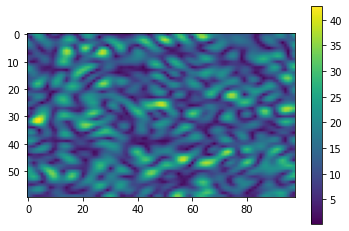

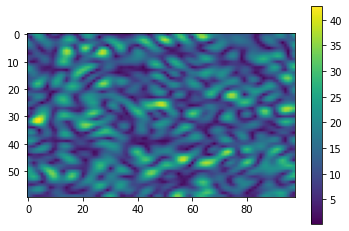

In [76]:
plt.imshow(np.abs(transf_1))
plt.colorbar()
plt.show()

plt.imshow(np.abs(transf_CUDA_Opt))
plt.colorbar()
plt.show()


In [72]:
print(100 * np.sqrt(np.sum(np.sum(np.abs(u_CUDA_Opt / np.max(np.abs(u_CUDA_Opt)) - u_CUDA / np.max(np.abs(u_CUDA)))**2)) / np.sum(np.sum(abs(u_CUDA / np.max(np.abs(u_CUDA_Opt)))**2))))

5.927569231668637e-21


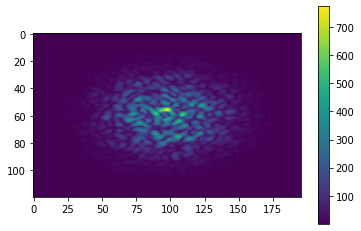

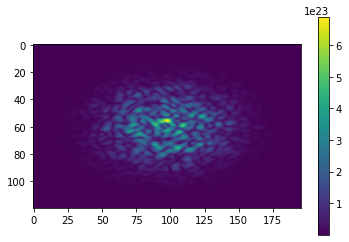

In [73]:
plt.imshow(np.abs(u_CUDA_Opt))
plt.colorbar()
plt.show()

plt.imshow(np.abs(u_CUDA))
plt.colorbar()
plt.show()


In [74]:
kk                = np.arange(-M / 2, M / 2)
xi                = 2 * np.pi * kk / (c * M)

def spatialWindowOpt_c_1_5_K_6_test(xi):

  x_in      = (2. * c - 1.) * xi / (2. * np.pi - np.pi / c)
  
  phi       = np.zeros((1, xi.size))
  
  fma_temp          = fma(-0.000000069910102,  x_in,  0.000009440083978)
  fma_temp          = fma(fma_temp,            x_in,  0.000000485373669)
  fma_temp          = fma(fma_temp,            x_in, -0.000130542860824)
  fma_temp          = fma(fma_temp,            x_in, -0.000001511196733)
  fma_temp          = fma(fma_temp,            x_in,  0.001007181146599)
  fma_temp          = fma(fma_temp,            x_in,  0.000002786045376)
  fma_temp          = fma(fma_temp,            x_in, -0.005861791424619)
  fma_temp          = fma(fma_temp,            x_in, -0.000003382240723)
  fma_temp          = fma(fma_temp,            x_in,  0.028542361926637)
  fma_temp          = fma(fma_temp,            x_in,  0.000002843935263)
  fma_temp          = fma(fma_temp,            x_in, -0.119965156296017)
  fma_temp          = fma(fma_temp,            x_in, -0.000001695763776)
  fma_temp          = fma(fma_temp,            x_in,  0.436044809334474)
  fma_temp          = fma(fma_temp,            x_in,  0.000000721634603)
  fma_temp          = fma(fma_temp,            x_in, -1.357516364933031)
  fma_temp          = fma(fma_temp,            x_in, -0.000000217506622)
  fma_temp          = fma(fma_temp,            x_in,  3.564588400278597)
  fma_temp          = fma(fma_temp,            x_in,  0.000000045421100)
  fma_temp          = fma(fma_temp,            x_in, -7.731821324183906)
  fma_temp          = fma(fma_temp,            x_in, -0.000000006311966)
  fma_temp          = fma(fma_temp,            x_in, 13.464987789472458)
  fma_temp          = fma(fma_temp,            x_in,  0.000000000545447)
  fma_temp          = fma(fma_temp,            x_in,-18.069347531398041)
  fma_temp          = fma(fma_temp,            x_in, -0.000000000026086)
  fma_temp          = fma(fma_temp,            x_in, 17.513523641932530)
  fma_temp          = fma(fma_temp,            x_in,  0.000000000000553)
  fma_temp          = fma(fma_temp,            x_in,-10.896373263737980)
  fma_temp          = fma(fma_temp,            x_in, -0.000000000000003)
  phi               = fma(fma_temp,            x_in,  3.263548456418927)
  
  return phi

  y = spatialWindowOpt_c_1_5_K_6_test(xi)

  print(y)

  plt.plot(xi, y)
  plt.show()

1.5184364492350668


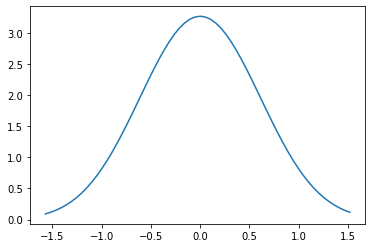

In [75]:
kk                = np.arange(-M / 2, M / 2)
xi                = 2 * np.pi * kk / (c * M)

y = spatialWindowOpt_c_1_5_K_6_test(xi)

print(np.max(xi))

plt.plot(xi, y)
plt.show()